在本教程中，我们将使用 CIFAR10 数据集。它有类： 'airplane'， 'automobile'， 'bird'， 'cat'， 'deer'， 'dog'， 'frog'， 'horse'， 'ship'， 'truck'。CIFAR-10 中的图像尺寸为 3x32x32，即 32x32 像素大小的 3 通道彩色图像。

![](https://pytorch.org/tutorials/_images/cifar10.png)

#1.训练图像分类器
我们将按顺序执行以下步骤：

1.使用 torchvision 加载和规范化 CIFAR10 训练和测试数据集

2.定义卷积神经网络

3.定义损失函数

4.在训练数据上训练网络

5.在测试数据上测试网络

6.在GPU上进行训练


## 1. 加载并规范化CIFAR10

使用 torchvision，加载 CIFAR10 非常容易。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

数据集的输出是范围 [0， 1] 的 PILImage 图像。我们将它们转换为归一化范围 [-1， 1] 的 Tensor。

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 66786027.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


让我们展示一些训练图像，以便有直觉。

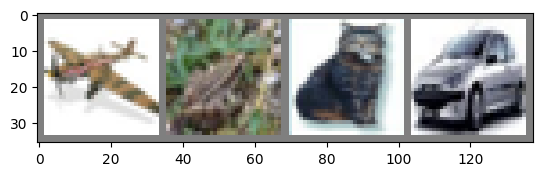

plane frog  cat   car  


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 2. 定义卷积神经网络

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3. 定义 Loss 函数和优化器

让我们使用 Classification Cross-Entropy 损失和带有动量的 SGD。

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4. 训练网络
接下来就交给迭代。我们只需要遍历我们的数据迭代器，并将输入馈送到网络并进行优化。

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.176
[1,  4000] loss: 1.858
[1,  6000] loss: 1.683
[1,  8000] loss: 1.589
[1, 10000] loss: 1.525
[1, 12000] loss: 1.487
[2,  2000] loss: 1.416
[2,  4000] loss: 1.389
[2,  6000] loss: 1.358
[2,  8000] loss: 1.342
[2, 10000] loss: 1.332
[2, 12000] loss: 1.294
Finished Training


让我们快速保存经过训练的模型：

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. 在测试数据上测试网络

我们已经在训练数据集上训练了网络 2 次。但是我们需要检查网络是否学到了任何东西。

我们将通过预测神经网络输出的类标签，并根据真实值进行检查来检查这一点。如果预测正确，我们将样本添加到正确预测列表中。

先显示测试数据集

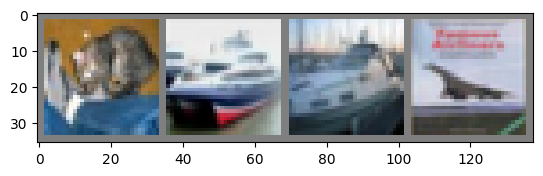

GroundTruth:  cat   ship  ship  plane


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

接下来，让我们重新加载已保存的模型（注意：这里不需要保存和重新加载模型，我们这样做只是为了说明如何做到这一点）：

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

好，现在让我们看看神经网络是怎么看上面的这些图像的：

In [11]:
outputs = net(images)

In [13]:
outputs

tensor([[-1.0725, -1.6780,  1.1681,  2.2050,  0.9274,  1.7737,  1.0481, -1.0913,
         -0.4209, -1.4085],
        [ 5.4224,  5.9985, -1.5434, -2.8805, -2.6383, -4.4900, -4.2164, -6.0958,
          8.5752,  2.5276],
        [ 1.7580,  3.1368, -1.2011, -1.0405, -1.5549, -2.0099, -2.0978, -2.9073,
          4.4290,  2.0543],
        [ 4.2048,  0.9328, -0.3463, -1.4392, -0.4173, -2.9438, -2.7904, -2.9345,
          5.9328,  0.4980]], grad_fn=<AddmmBackward0>)

输出是 10 个类的能量。类的能量越高，网络就越认为该图像属于特定类。那么，让我们得到最高能量的指数：

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


让我们看看网络在整个数据集上的表现如何。

In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


表现良好的类有哪些，表现不佳的类有哪些：

In [15]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 54.2 %
Accuracy for class: car   is 69.9 %
Accuracy for class: bird  is 45.9 %
Accuracy for class: cat   is 27.9 %
Accuracy for class: deer  is 53.6 %
Accuracy for class: dog   is 38.7 %
Accuracy for class: frog  is 60.0 %
Accuracy for class: horse is 57.5 %
Accuracy for class: ship  is 85.3 %
Accuracy for class: truck is 47.4 %


## 在 GPU 上训练

如果我们有可用的 CUDA，让我们首先将我们的设备定义为第一个可见的 cuda 设备：

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


本节的其余部分假定该设备是 CUDA 设备。

In [19]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

请记住，还必须在每个步骤中将输入和目标发送到 GPU：

In [18]:
inputs, labels = data[0].to(device), data[1].to(device)